# Modelo LSTM e vetorização Glove

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

## Carregamento do dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Carregando o dataset
df = pd.read_csv('/content/drive/MyDrive/Spam_Detection/SPAM.csv')

# Exibindo o dataframe resultante
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Análise exploratória

### Verificando o tamanho do dataset

In [ ]:
print(f'Linhas: {df.shape[0]}')
print(f'Colunas: {df.shape[1]}')

Linhas: 5572
Colunas: 2


### Buscando informações sobre as colunas e cada tipo de dado

In [ ]:
df.dtypes

,0
Category,object
Message,object


### Verificando colunas não preenchidas

In [ ]:
df.isna().sum()

,0
Category,0
Message,0


### Verificando valores missing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


# Distribuição das variáveis qualitativas

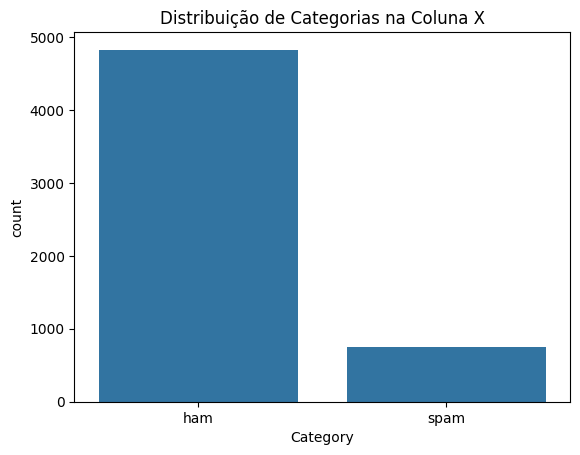

In [ ]:
sns.countplot(data=df, x='Category')
plt.title('Distribuição de Categorias na Coluna X')
plt.show()

### Verificando o tamanho das mensagens

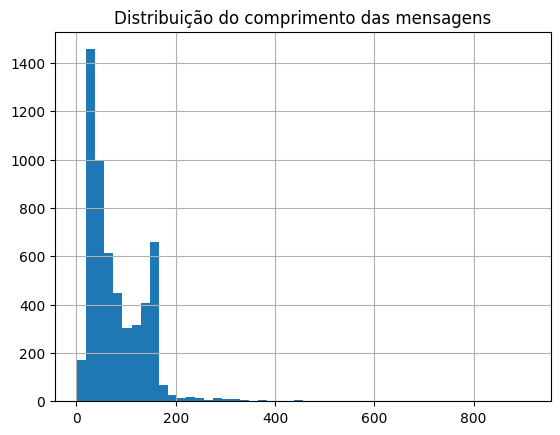

In [ ]:
# Tamanho das mensagens
df['text_length'] = df['Message'].apply(len)
df['text_length'].hist(bins=50)
plt.title('Distribuição do comprimento das mensagens')
plt.show()

### Analisando as correlações entre as variáveis

In [ ]:
# Função para calcular a correlação de Cramér-V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

In [ ]:
result = cramers_v(df['Category'], df['Message'])
print(f"Correlação de Cramér-V: {result}")

Correlação de Cramér-V: 0.27295839181545156


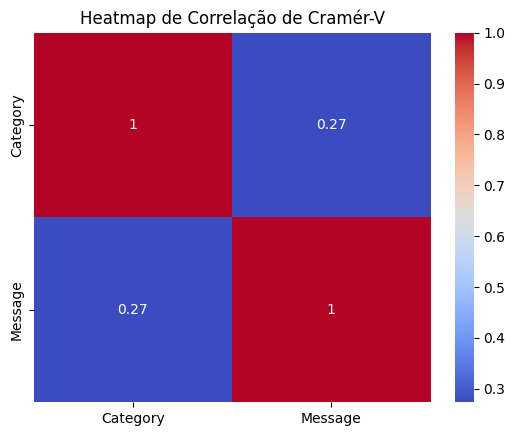

In [ ]:
# Criando matriz de correlação para várias variáveis categóricas
columns = ['Category', 'Message']
corr_matrix = pd.DataFrame(index=columns, columns=columns)

for col1 in columns:
    for col2 in columns:
        corr_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

# Mapa de calor
sns.heatmap(corr_matrix.astype(float), annot=True, cmap='coolwarm')
plt.title('Heatmap de Correlação de Cramér-V')
plt.show()

### Análise exploratória com Pandas Profiling

https://viniciusrochalima.medium.com/turbinando-as-suas-an%C3%A1lises-explorat%C3%B3rias-cbe788993106

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip -q

     | 17.8 MB 17.0 MB/s 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 65.2 MB/s eta 0:00:00


In [ ]:
from pandas_profiling import ProfileReport

<ipython-input-27-e2a33329b6f0>:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [ ]:
report = ProfileReport(df)
report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Pré-processamento

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Converte para minúsculas
    text = text.lower()
    # Tokeniza
    tokens = word_tokenize(text)
    # Remove stopwords e lematiza
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

df['cleaned_text'] = df['Message'].apply(preprocess)

In [ ]:
df[['Message', 'cleaned_text']].head()

,Message,cleaned_text
0,"Go until jurong point, crazy.. Available only ...","go jurong point , crazy .. available bugis n g..."
1,Ok lar... Joking wif u oni...,ok lar ... joking wif u oni ...
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...
3,U dun say so early hor... U c already then say...,u dun say early hor ... u c already say ...
4,"Nah I don't think he goes to usf, he lives aro...","nah n't think go usf , life around though"


## Vetorização usando Glove

In [ ]:
# Carregando o modelo Glove
glove_embeddings = {}
with open('/content/drive/MyDrive/Spam_Detection/glove.6B/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

In [ ]:
# Vetorizando as frases
def vectorize_sentence(sentence, embeddings, dim=100):
    words = sentence.split()
    vector = np.zeros(dim)
    for word in words:
        if word in embeddings:
            vector += embeddings[word]
    return vector

In [ ]:
df['glove_vector'] = df['cleaned_text'].apply(lambda x: vectorize_sentence(x, glove_embeddings))

In [ ]:
df[['cleaned_text', 'glove_vector']].head()

,cleaned_text,glove_vector
0,"go jurong point , crazy .. available bugis n g...","[-1.2709799529984593, 2.002364018931985, 6.505..."
1,ok lar ... joking wif u oni ...,"[0.12567300722002983, 0.16059298813343048, 4.4..."
2,free entry 2 wkly comp win fa cup final tkts 2...,"[0.34653705917298794, 4.591520022600889, 8.389..."
3,u dun say early hor ... u c already say ...,"[-1.8211280480027199, 2.7187953870743513, 3.35..."
4,"nah n't think go usf , life around though","[-0.6386662274599075, 3.5766899660229683, 3.78..."


## Modelo LSTM

In [ ]:
# Mapeando as categorias para números
df['Category'] = df['Category'].map({'ham': 0, 'spam': 1})

In [ ]:
df[['Category']].head()

,Category
0,0
1,0
2,1
3,0
4,0


In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from sklearn.model_selection import train_test_split


In [ ]:
# Definindo o modelo LSTM
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=100))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compilando o modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Treinando o modelo
X = np.stack(df['glove_vector'].values)
y = df['Category'].values
# Separando os dados em treino (80%) e validação (20%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando o modelo com os dados de treino
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.9141 - loss: 0.2216 - val_accuracy: 0.9103 - val_loss: 0.2303
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 117ms/step - accuracy: 0.9265 - loss: 0.2087 - val_accuracy: 0.9166 - val_loss: 0.2139
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.9296 - loss: 0.1919 - val_accuracy: 0.9202 - val_loss: 0.2043
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.9355 - loss: 0.1799 - val_accuracy: 0.9283 - val_loss: 0.2091
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.9376 - loss: 0.1695 - val_accuracy: 0.9300 - val_loss: 0.1922


## Avaliação com matriz de confusão

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
# Predizendo no conjunto de validação
y_pred = model.predict(X_val)
y_pred_classes = [1 if prob > 0.5 else 0 for prob in y_pred]

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [ ]:
# Acurácia
acc = accuracy_score(y_val, y_pred_classes)
print(f'Acurácia: {acc}')

Acurácia: 0.9300448430493273


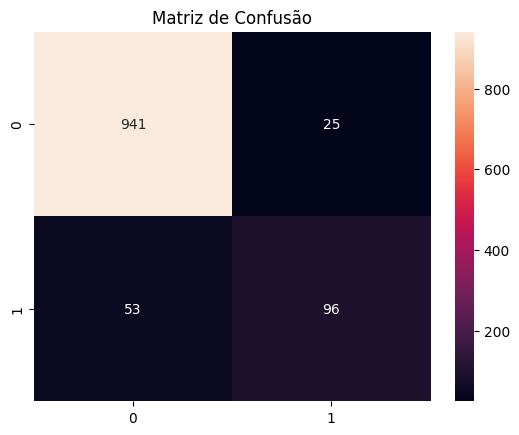

In [ ]:
# Matriz de Confusão
cm = confusion_matrix(y_val, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Matriz de Confusão')
plt.show()

# Outra abordagem com modelo MLP e vetorização TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['cleaned_text']).toarray()

In [ ]:
# Separando os dados em treino e validação
X_train_tfidf, X_val_tfidf, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [ ]:
# Definindo e treinando o modelo MLP
mlp = MLPClassifier(hidden_layer_sizes=(64,), max_iter=10)
mlp.fit(X_train_tfidf, y_train)

# Predição no conjunto de validação
y_pred_mlp = mlp.predict(X_val_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Avaliação da acurácia
from sklearn.metrics import accuracy_score
acc_mlp = accuracy_score(y_val, y_pred_mlp)
acc_mlp

0.9829596412556054

## Matriz de confusão TF-IDF

In [ ]:
# Gerando a matriz de confusão
cm_mlp = confusion_matrix(y_val, y_pred_mlp)

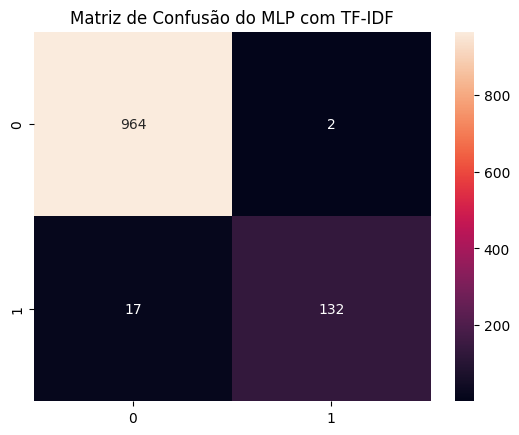

In [ ]:
# Exibindo a matriz de confusão
sns.heatmap(cm_mlp, annot=True, fmt='d')
plt.title('Matriz de Confusão do MLP com TF-IDF')
plt.show()